In [56]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
#sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

## Toy model

Input X - corresponds to any kind of phase space input - some **distribution** with prior.
Input $\mu$ - corresponds to parameters of surrogate, ie - size of detector, magnetic field, etc. - a **number**.

Define some functions f, g - those can be varied. Probably, bettern to stick with some types of them, ie:
continous, pereodic, polynomial, ...

$$X \sim U(x_{min}, x_{max}), \ \ \mu \sim \delta(\mu - \mu_0) $$

$$latent\_x \sim  \mathcal{N} (latent\_x | X, 1)$$


$$ f(\alpha) = a + b \alpha  $$
$$ g(\alpha) = d * \alpha $$

$$y \sim \mathcal{N}(y|f(latent\_x) + g(\mu), 1)$$

### Problem statement

1. Fit GAN/GP/NV to match p(y|X,mu)

2. Solve optimisaiton problem of the choise:
 - $argmin_{mu} (y - Y_0) ^2 $
 - $argmax_{mu} p(y|mu) = \int p(y|X,mu) p(X) dx$
 - $etc$



## Make model with `pyro`

In [454]:
class YModel(object):
    def __init__(self, x_range=(-10,10), init_mu = 0):
        self.mu_dist = dist.Delta(torch.tensor(float(init_mu), requires_grad=False))
        self.x_dist = dist.Uniform(*x_range)
    
    @staticmethod
    def f(x, a=1, b=1, c=2):
        return a + b * x
    @staticmethod
    def g(x, d=1):
        return d * x
    
    def sample(self, sample_size=1):
        mu = pyro.sample('mu', self.mu_dist, torch.Size([sample_size]))
        if mu.size() == torch.Size([]):
            size = [1]
        else:
            size = mu.size()
        X = pyro.sample('X', self.x_dist, size)

        latent_x = pyro.sample('latent_x', dist.Normal(X, 1))#.double()
        latent_x = self.f(latent_x)

        latent_mu = self.g(mu)#.double()
        return pyro.sample('y', dist.Normal(latent_x + latent_mu, 1))
    
    def make_condition_sample(self, data):
        self.condition_sample = poutine.condition(self.sample, data=data)
    
    def condition_sample(self, size=1):
        return self.condition_sample(size)


## Investigation of the model

In [455]:
y_sampler = YModel()

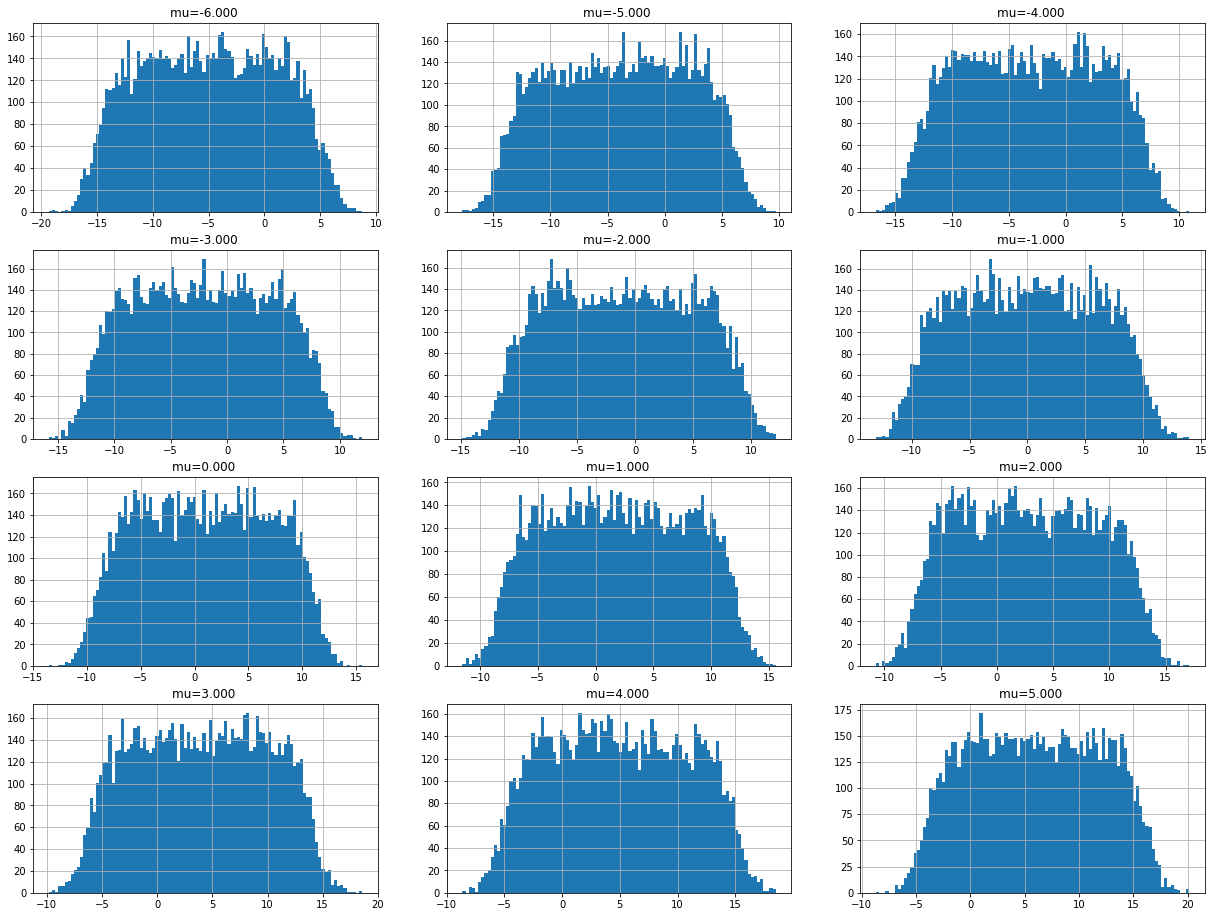

In [432]:
plt.figure(figsize=(21,16))
mu = list(range(-6, 6, 1))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'mu': torch.tensor([float(mu[i*3 + j])] * 10000)})
        plt.hist(y_sampler.condition_sample().detach().numpy(), bins=100);
        plt.grid()
        #plt.legend()
        plt.title("mu={:.3f} ".format(mu[i*3 + j]))

CPU times: user 1.04 s, sys: 4 ms, total: 1.04 s
Wall time: 1.04 s


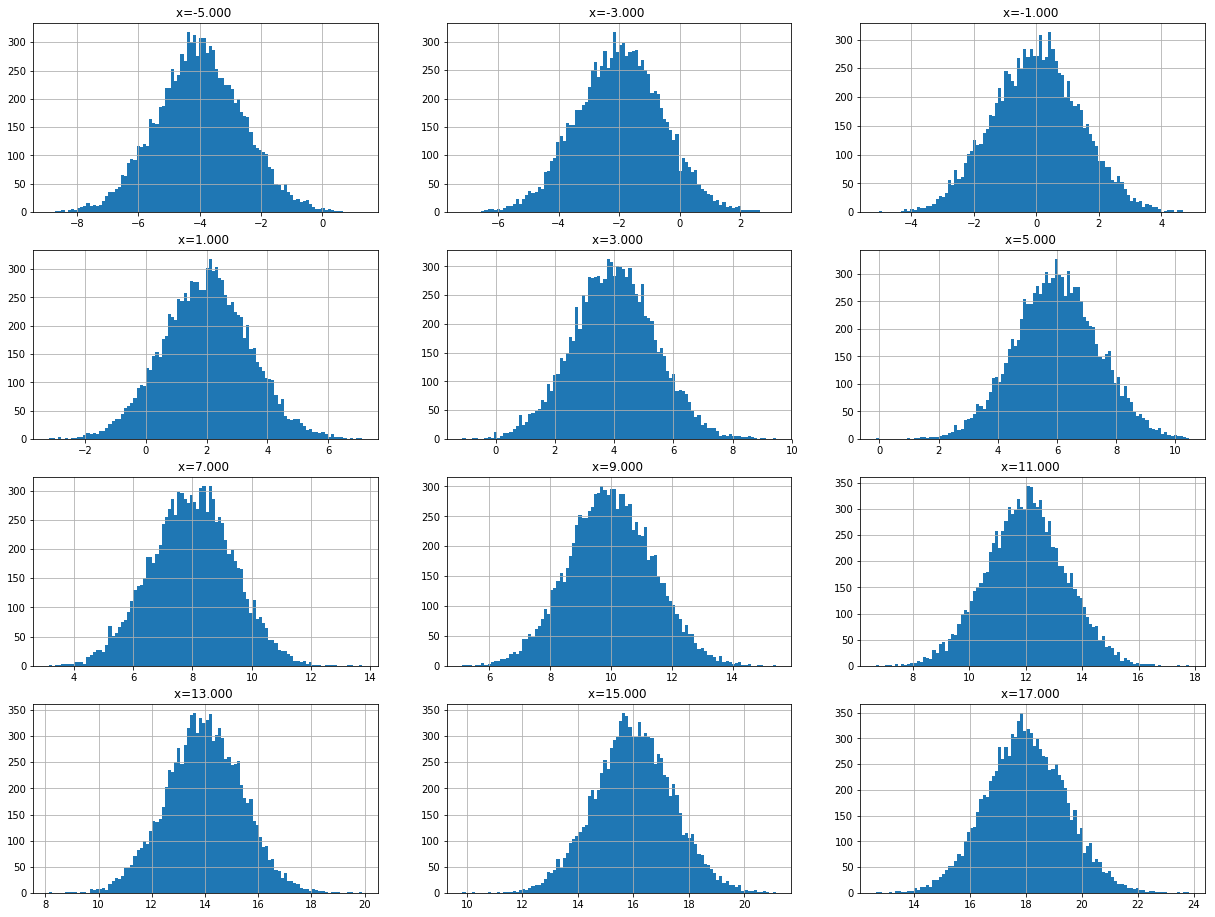

In [433]:
%%time
plt.figure(figsize=(21,16))
x_r = list(range(-5, 18, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'X': torch.tensor([float(x_r[i*3 + j])] * 10000)})
        plt.hist(y_sampler.condition_sample(10000).detach().numpy(), bins=100);
        plt.grid()
        #plt.legend()
        plt.title("x={:.3f} ".format(x_r[i*3 + j]))

In [434]:
# mu_r = torch.arange(-100, 100, 1, dtype=torch.double)
# x_r = y_sampler.x_dist.sample([100, len(mu_r)])

# y_sampler.make_condition_sample({'mu': mu_r, 'X': x_r})
# y = y_sampler.condition_sample()


# plt.figure(figsize=(12,6))
# plt.pcolormesh(mu_r, x_r, y);
# plt.colorbar()
# plt.xlabel(r'$\mu$');
# plt.ylabel("X");

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [360]:
def R(ys: torch.tensor, Y_0=-5):
    return (ys - Y_0).pow(2).mean()

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

In [361]:
import numpy as np

rs = []
mus = np.linspace(-25, 25, 100)
for mu in tqdm.tqdm(mus):
    y_sampler.make_condition_sample({'mu': torch.tensor([mu] * 10000)})
    samples = y_sampler.condition_sample()
    rs.append(R(samples).item())

100%|██████████| 100/100 [00:02<00:00, 35.24it/s]


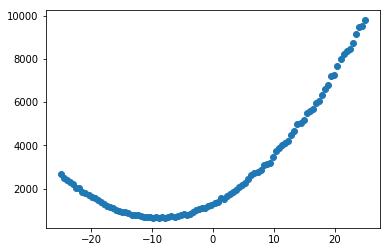

In [362]:
plt.scatter(mus, rs)

In [363]:
mus[np.argmin(rs)], np.min(rs)

(-7.828282828282827, 647.9463500976562)

In [248]:
rs = []
xs = np.linspace(-100, 100, 100)
for x in tqdm.tqdm(xs):
    y_sampler.make_condition_sample({'X': torch.tensor([x] * 10000)})
    samples = y_sampler.condition_sample()    
    rs.append(R(samples).item())

100%|██████████| 100/100 [00:00<00:00, 627.71it/s]


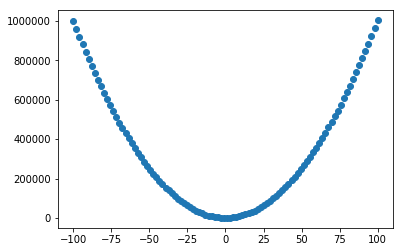

In [249]:
plt.scatter(xs, rs)

In [227]:
xs[np.argmin(rs)], np.min(rs)

/mnt/shirobokov/conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(-100.0, nan)